In [1]:
### Import the required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cmocean

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
from keras import metrics
import innvestigate

import os
from os.path import join
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

import random

# See if GPUs are available
from keras import backend as K
if bool(K._get_available_gpus()):
    print("Running on GPU")
else:
    print("Running on CPU")

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

### https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed ###
### https://keras.io/examples/keras_recipes/reproducibility_recipes/ ###
SEED = 1997
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

tf.compat.v1.disable_eager_execution()

2024-02-29 13:17:09.654482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 13:17:11.090795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-29 13:17:11.093297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-29 13:17:11.095388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/rep

Running on GPU


In [2]:
### Sverdrup 
# mainDir_r4  = '/scratch2/pillarh/eccov4r4'
# mainDir_r5  = '/scratch2/pillarh/eccov4r5'
# gridDir  = mainDir_r4 + '/GRID'
# thetaDir = mainDir_r5 + '/V4r5/diags_daily/SST_day_mean'
# thetaDir_ext = mainDir_r5 + '/V4r5_ext_2020_2023_Jun/diags_daily/SST_day_mean'

## LS6
mainDir_r4 = '/work/07665/shrey911/ls6/LRP_eccov4r4_data'
mainDir_r5 = '/work/07665/shrey911/ls6/LRP_eccov4r5_data'
gridDir  = mainDir_r5 + '/GRID'
thetaDir = mainDir_r5 + '/SST_day_mean'
thetaDir_ext = mainDir_r5 + '/SST_day_mean_ext_2020_2023_Jun'

# For Sverdrup
# ds_r4 = xr.open_dataset(f'/scratch2/shreyas/LRP_eccov4r4_data/thetaSurfECCOv4r4.nc')
# For LS6
ds_r4 = xr.open_dataset(mainDir_r4 + '/thetaSurfECCOv4r4.nc')

# SSH has to be kept because someone used the SSH metadata for SST, 
# It's not a bug in this code but a hack to handle an existing bug.
temp = xmitgcm.open_mdsdataset(data_dir = thetaDir,
                             grid_dir = gridDir,
                             extra_variables = dict(SSH = dict(dims=['k','j','i'],
                                                               attrs = dict(standard_name="SST",
                                                                            long_name="Sea Surface Temperature",
                                                                            units="degC"))))
temp["SST"] = temp["SSH"]
temp = temp.drop(["SSH"])
    
temp_ext = xmitgcm.open_mdsdataset(data_dir = thetaDir_ext,
                                 grid_dir = gridDir,
                                 extra_variables = dict(SST = dict(dims=['k','j','i'],
                                                                   attrs = dict(standard_name="SST",
                                                                                long_name="Sea Surface Temperature",
                                                                                units="degC"))))

ds_r5 = xr.concat([temp, temp_ext], "time")

In [3]:
ds_SST = xr.open_dataset(mainDir_r5+'/SST_all.nc')
SST = ds_SST['SST'].data

In [4]:
hFacC = ecco.read_llc_to_tiles(gridDir, 'hFacC.data')
hFacC_mask = hFacC > 0
hFacC_mask = hFacC_mask.astype(float)

XC = ds_r4['XC'].data
YC = ds_r4['YC'].data

latMask = YC > -20.0
latMask = latMask.astype(float)

maskFinal = hFacC_mask * latMask
NaNmaskFinal = np.copy(maskFinal)
NaNmaskFinal[NaNmaskFinal == 0] = np.nan

da_XC = xr.DataArray(
    data=ds_r4['XC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="XC"),
)

da_YC = xr.DataArray(
    data=ds_r4['YC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="YC"),
)

da_hFacC_mask = xr.DataArray(
    data=hFacC_mask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="hFacC mask 2D 1 if > 0, else 0"),
)

da_latMask = xr.DataArray(
    data=latMask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Latitude Mask 1 if > -20, else 0"),
)

da_maskFinal = xr.DataArray(
    data=maskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D 1 if > 0, else 0"),
)

da_NaNmaskFinal = xr.DataArray(
    data=NaNmaskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D True if > 0, else NaN"),
)

wetpoints = np.nonzero(maskFinal.data)
da_wetpoints = xr.DataArray(
    data=np.asarray(wetpoints),
    dims=["wetpoints_dim", "num_wetpoints"],
    coords=dict(
        wetpoints_dim = np.arange(np.asarray(wetpoints).shape[0], dtype = int),
        num_wetpoints = np.arange(np.asarray(wetpoints).shape[1], dtype = int),
    ),
    attrs=dict(description="indices of wetpoints in the order (tile, j, i) in the three rows"),
)

da_SST = xr.DataArray(
    data=SST,
    dims=["time", "tile", "j", "i"],
    coords=dict(
        time = ds_r5['time'].data[:SST.shape[0]],
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="SST field in llc format"),
)

ds = xr.Dataset()
ds = ds.assign(XC           = da_XC,
               YC           = da_YC,
               hFacC_mask   = da_hFacC_mask,
               latMask      = da_latMask,
               maskFinal    = da_maskFinal,
               NaNmaskFinal = da_NaNmaskFinal,
               wetpoints    = da_wetpoints,
               SST          = da_SST)

load_binary_array: loading file /work/07665/shrey911/ls6/LRP_eccov4r5_data/GRID/hFacC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [5]:
def anomalize(field):
    
    leap_yr_offsets_jan_feb   = [0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8]
    leap_yr_offsets_after_feb = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8]

    if len(field.shape) > 1:
        seasonal_trend = np.zeros((366, field.shape[1]))
    else:
        seasonal_trend = np.zeros((366,))

    #### Calculate seasonal trend
    
    # Jan 1 - Feb 28
    for d in range(59):
        for year in range(31):
            seasonal_trend[d] += field[d+365*year+leap_yr_offsets_jan_feb[year]]
    seasonal_trend[:59] = seasonal_trend[:59] / 31.0
    
    # Feb 29 starting 1996, so year 2 in 0-indefielding
    n = 0
    for year in range(0,31,4):
        seasonal_trend[59] += field[365*year+n+59]
        n = n+1
    seasonal_trend[59] = seasonal_trend[59] / 8.0
            
    # Mar 1 - Dec 31
    for d in range(60,366):
        for year in range(31):
            seasonal_trend[d] += field[d-1+365*year+leap_yr_offsets_after_feb[year]]
    seasonal_trend[60:] = seasonal_trend[60:] / 31.0
    
    #### Deseason data
    
    # Jan 1 - Feb 28
    for d in range(59):
        for year in range(31):
            field[d+365*year+leap_yr_offsets_jan_feb[year]] = field[d+365*year+leap_yr_offsets_jan_feb[year]] \
                                                        - seasonal_trend[d]
    
    # Feb 29 starting 1996, so year 2 in 0-indexing
    n = 0
    for year in range(0,31,4):
        field[365*year+n+59] = field[365*year+n+59] - seasonal_trend[59]
        n = n+1
            
    # Mar 1 - Dec 31
    for d in range(60,366):
        for year in range(31):
            field[d-1+365*year+leap_yr_offsets_after_feb[year]] = field[d-1+365*year+leap_yr_offsets_after_feb[year]] \
                                                            - seasonal_trend[d]

    scipy.signal.detrend(field, axis=0, type='linear', bp=0, overwrite_data=True)
    field = field - np.mean(field, axis = 0)

    return field

In [6]:
X = ds['SST'].data[:,wetpoints[0],wetpoints[1],wetpoints[2]].copy()
X = anomalize(X)
X_full = X.copy()
X = X[30:-30]

y = ds['SST'].isel(tile = 10, j = 1, i = 43).data.copy()
y = anomalize(y)
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
y = np.convolve(y, np.ones(61)/61, mode='valid')
oneHotCost = np.zeros((y.shape[0], 2), dtype = int)
oneHotCost[:,0] = y >= 0.0
oneHotCost[:,1] = y <  0.0

In [7]:
da_X = xr.DataArray(
    data=X,
    dims=["time_allData", "num_wetpoints"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data as matrix X; deseasoned, delinearized and mean removed."),
)

da_y = xr.DataArray(
    data=y,
    dims=["time_allData"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
    ),
    attrs=dict(description="All cost function y; deseasoned, delinearized and mean removed."),
)

da_X_full = xr.DataArray(
    data=X_full,
    dims=["time", "num_wetpoints"],
    coords=dict(
        time          = ds['time'],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data without accounting for conv filter as matrix X_full; deseasoned, delinearized and mean removed."),
)

da_oneHotCost = xr.DataArray(
    data=oneHotCost,
    dims=["time_allData", "NN_output_dim"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        NN_output_dim = np.array([0,1]),
    ),
    attrs=dict(description="All cost function as one-hot vector."),
)

ds = ds.assign(X          = da_X,
               y          = da_y,
               X_full     = da_X_full,
               oneHotCost = da_oneHotCost)

## Optimal Input

In [8]:
def quickSetup(X, y,
               test_split_frac,
               lagSteps,
               desired_labels,
               compute_loss,
               OI_eta,
               OI_epochs,
               OI_print_freq,
               decay_func = None,
               **NNkwargs):

    idx = int(X.shape[0]*(1-test_split_frac))
    X_train = X[:idx]
    oneHotCost_train = oneHotCost[:idx]
    X_test = X[idx:]
    oneHotCost_test = oneHotCost[idx:]

    keras.backend.clear_session()
    sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    NNkwargs['optimizer'] = sgd
    
    if lagSteps > 0:
        K = TrainFullyConnectedNN(X_train[:-lagSteps], oneHotCost_train[lagSteps:], **NNkwargs)
    elif lagSteps == 0:
        K = TrainFullyConnectedNN(X_train, oneHotCost_train, **NNkwargs)
    else:
        K = TrainFullyConnectedNN(X_train[-lagSteps:], oneHotCost_train[:lagSteps], **NNkwargs)
        
    best_model = K.quickTrain(decay_func)

    oi = OI(best_model, desired_labels, 
          compute_loss, OI_eta, OI_epochs, OI_print_freq)
    
    return oi

def compute_loss(desired_labels, pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(desired_labels, pred)

def OI(model, desired_labels_numpy, compute_loss, eta, max_iters, print_freq):
    
    inp_numpy = np.zeros((1, X.shape[1]), dtype = float)

    if len(desired_labels_numpy.shape) == 1:
        desired_labels_numpy = desired_labels_numpy[np.newaxis, :]
        
    desired_labels = tf.convert_to_tensor(desired_labels_numpy)
    print(f"Desired label : {desired_labels_numpy}")
    
    for i in range(max_iters):
        inp = tf.convert_to_tensor(inp_numpy)
        grads = GradientDescent_useGradientTape(model, inp, desired_labels, compute_loss)
        grads_numpy = np.squeeze(tf_to_numpy(grads))
        inp_numpy[0,:] = inp_numpy[0,:] - eta*grads_numpy
        if (i+1)%print_freq == 0:
            print(f"Iter {i+1}, Prediction {tf_to_numpy(model.predict(inp_numpy))}")

    optimal_input = np.zeros((13,90,90), dtype = float)
    optimal_input[wetpoints[0], wetpoints[1], wetpoints[2]] = inp_numpy[0]
    
    return optimal_input

In [9]:
Layers = [{'size': X.shape[1], 'activation': None     , 'use_bias': None},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 10.0, 'l2_b_reg': 10.0},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01},
          {'size': 2         , 'activation': 'softmax', 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01}]

Losses = [{'kind': 'categorical_crossentropy', 'weight': 1.0}]

LRPDict_theta = {}
lagStepsList = [-60,-30,0,30,60,90,120,150,180]

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 50
    lrate = initial_lrate * drop**np.floor((1+epoch)/epochs_drop)
    return lrate

OI_dict = {}
OI_eta = 0.9999
OI_epochs = 8000
OI_print_freq = 200

In [10]:
for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Theta')
    
    NNkwargs = {'losses': Losses, 'metrics': [metrics.categorical_accuracy],
                'batch_size': 128, 'epochs': 500, 'validation_split': 0.1,
                'filename': f'model{lagStepsList[i]}_OI', 'dirname': os.path.abspath(''),
                'random_nn_seed': 42}
    
    OI_dict[f'lag{lagStepsList[i]}'] = quickSetup(X, y, 2191.0/11323.0,
                                             lagStepsList[i],
                                             np.array([[0.0,1.0]]),
                                             compute_loss,
                                             OI_eta,
                                             OI_epochs,
                                             OI_print_freq,
                                             step_decay,
                                             layers = Layers, **NNkwargs)

Lag: -60 days, for Theta


2024-02-29 13:19:44.606383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-29 13:19:44.608415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-29 13:19:44.610408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0
2024-02-29 13:19:44.623587: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-02-29 13:19:47.690106: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] Ten


Epoch 1: val_loss improved from inf to 1.40382, saving model to /home1/07665/shrey911/XAIRT/examples/model-60_OI.h5

Epoch 2: val_loss improved from 1.40382 to 1.15039, saving model to /home1/07665/shrey911/XAIRT/examples/model-60_OI.h5

Epoch 3: val_loss did not improve from 1.15039

Epoch 4: val_loss did not improve from 1.15039

Epoch 5: val_loss improved from 1.15039 to 0.55877, saving model to /home1/07665/shrey911/XAIRT/examples/model-60_OI.h5

Epoch 6: val_loss did not improve from 0.55877

Epoch 7: val_loss did not improve from 0.55877

Epoch 8: val_loss did not improve from 0.55877

Epoch 9: val_loss did not improve from 0.55877

Epoch 10: val_loss did not improve from 0.55877

Epoch 11: val_loss did not improve from 0.55877

Epoch 12: val_loss did not improve from 0.55877

Epoch 13: val_loss did not improve from 0.55877

Epoch 14: val_loss did not improve from 0.55877

Epoch 15: val_loss improved from 0.55877 to 0.53548, saving model to /home1/07665/shrey911/XAIRT/examples/m

2024-02-29 14:41:02.765382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-29 14:41:02.767458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-29 14:41:02.769937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.21049, saving model to /home1/07665/shrey911/XAIRT/examples/model-30_OI.h5

Epoch 2: val_loss improved from 1.21049 to 0.85111, saving model to /home1/07665/shrey911/XAIRT/examples/model-30_OI.h5

Epoch 3: val_loss did not improve from 0.85111

Epoch 4: val_loss did not improve from 0.85111

Epoch 5: val_loss did not improve from 0.85111

Epoch 6: val_loss improved from 0.85111 to 0.58169, saving model to /home1/07665/shrey911/XAIRT/examples/model-30_OI.h5

Epoch 7: val_loss did not improve from 0.58169

Epoch 8: val_loss improved from 0.58169 to 0.55525, saving model to /home1/07665/shrey911/XAIRT/examples/model-30_OI.h5

Epoch 9: val_loss did not improve from 0.55525

Epoch 10: val_loss did not improve from 0.55525

Epoch 11: val_loss improved from 0.55525 to 0.47266, saving model to /home1/07665/shrey911/XAIRT/examples/model-30_OI.h5

Epoch 12: val_loss did not improve from 0.47266

Epoch 13: val_loss improved from 0.47266 to 0.46544, saving

2024-02-29 16:10:38.037421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-29 16:10:38.039500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-29 16:10:38.041564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.54767, saving model to /home1/07665/shrey911/XAIRT/examples/model0_OI.h5

Epoch 2: val_loss improved from 1.54767 to 0.70179, saving model to /home1/07665/shrey911/XAIRT/examples/model0_OI.h5

Epoch 3: val_loss did not improve from 0.70179

Epoch 4: val_loss did not improve from 0.70179

Epoch 5: val_loss improved from 0.70179 to 0.64709, saving model to /home1/07665/shrey911/XAIRT/examples/model0_OI.h5

Epoch 6: val_loss did not improve from 0.64709

Epoch 7: val_loss did not improve from 0.64709

Epoch 8: val_loss did not improve from 0.64709

Epoch 9: val_loss improved from 0.64709 to 0.59724, saving model to /home1/07665/shrey911/XAIRT/examples/model0_OI.h5

Epoch 10: val_loss did not improve from 0.59724

Epoch 11: val_loss did not improve from 0.59724

Epoch 12: val_loss did not improve from 0.59724

Epoch 13: val_loss did not improve from 0.59724

Epoch 14: val_loss improved from 0.59724 to 0.56358, saving model to /home1/07665/shrey911/

2024-02-29 17:39:21.575704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-29 17:39:21.578325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-29 17:39:21.580544: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 1.15207, saving model to /home1/07665/shrey911/XAIRT/examples/model30_OI.h5

Epoch 2: val_loss improved from 1.15207 to 0.94666, saving model to /home1/07665/shrey911/XAIRT/examples/model30_OI.h5

Epoch 3: val_loss did not improve from 0.94666

Epoch 4: val_loss improved from 0.94666 to 0.80831, saving model to /home1/07665/shrey911/XAIRT/examples/model30_OI.h5

Epoch 5: val_loss improved from 0.80831 to 0.61738, saving model to /home1/07665/shrey911/XAIRT/examples/model30_OI.h5

Epoch 6: val_loss did not improve from 0.61738

Epoch 7: val_loss did not improve from 0.61738

Epoch 8: val_loss did not improve from 0.61738

Epoch 9: val_loss did not improve from 0.61738

Epoch 10: val_loss did not improve from 0.61738

Epoch 11: val_loss improved from 0.61738 to 0.53740, saving model to /home1/07665/shrey911/XAIRT/examples/model30_OI.h5

Epoch 12: val_loss did not improve from 0.53740

Epoch 13: val_loss did not improve from 0.53740

Epoch 14: val_l

2024-02-29 19:12:40.094818: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-29 19:12:40.098639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-29 19:12:40.101229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.68338, saving model to /home1/07665/shrey911/XAIRT/examples/model60_OI.h5

Epoch 2: val_loss did not improve from 0.68338

Epoch 3: val_loss did not improve from 0.68338

Epoch 4: val_loss did not improve from 0.68338

Epoch 5: val_loss improved from 0.68338 to 0.63702, saving model to /home1/07665/shrey911/XAIRT/examples/model60_OI.h5

Epoch 6: val_loss did not improve from 0.63702

Epoch 7: val_loss improved from 0.63702 to 0.55930, saving model to /home1/07665/shrey911/XAIRT/examples/model60_OI.h5

Epoch 8: val_loss did not improve from 0.55930

Epoch 9: val_loss did not improve from 0.55930

Epoch 10: val_loss did not improve from 0.55930

Epoch 11: val_loss did not improve from 0.55930

Epoch 12: val_loss did not improve from 0.55930

Epoch 13: val_loss did not improve from 0.55930

Epoch 14: val_loss did not improve from 0.55930

Epoch 15: val_loss did not improve from 0.55930

Epoch 16: val_loss did not improve from 0.55930

Epoch 17: va

2024-02-29 20:48:46.968842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-29 20:48:46.972528: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-29 20:48:46.974836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.75181, saving model to /home1/07665/shrey911/XAIRT/examples/model90_OI.h5

Epoch 2: val_loss did not improve from 0.75181

Epoch 3: val_loss improved from 0.75181 to 0.61172, saving model to /home1/07665/shrey911/XAIRT/examples/model90_OI.h5

Epoch 4: val_loss did not improve from 0.61172

Epoch 5: val_loss did not improve from 0.61172

Epoch 6: val_loss improved from 0.61172 to 0.58737, saving model to /home1/07665/shrey911/XAIRT/examples/model90_OI.h5

Epoch 7: val_loss did not improve from 0.58737

Epoch 8: val_loss did not improve from 0.58737

Epoch 9: val_loss improved from 0.58737 to 0.53419, saving model to /home1/07665/shrey911/XAIRT/examples/model90_OI.h5

Epoch 10: val_loss did not improve from 0.53419

Epoch 11: val_loss did not improve from 0.53419

Epoch 12: val_loss did not improve from 0.53419

Epoch 13: val_loss did not improve from 0.53419

Epoch 14: val_loss did not improve from 0.53419

Epoch 15: val_loss did not improve fro

2024-02-29 22:26:13.372615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-02-29 22:26:13.376276: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-02-29 22:26:13.378462: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 2.06006, saving model to /home1/07665/shrey911/XAIRT/examples/model120_OI.h5

Epoch 2: val_loss did not improve from 2.06006

Epoch 3: val_loss did not improve from 2.06006

Epoch 4: val_loss did not improve from 2.06006

Epoch 5: val_loss improved from 2.06006 to 1.20800, saving model to /home1/07665/shrey911/XAIRT/examples/model120_OI.h5

Epoch 6: val_loss improved from 1.20800 to 0.73297, saving model to /home1/07665/shrey911/XAIRT/examples/model120_OI.h5

Epoch 7: val_loss did not improve from 0.73297

Epoch 8: val_loss did not improve from 0.73297

Epoch 9: val_loss did not improve from 0.73297

Epoch 10: val_loss did not improve from 0.73297

Epoch 11: val_loss did not improve from 0.73297

Epoch 12: val_loss improved from 0.73297 to 0.61185, saving model to /home1/07665/shrey911/XAIRT/examples/model120_OI.h5

Epoch 13: val_loss did not improve from 0.61185

Epoch 14: val_loss did not improve from 0.61185

Epoch 15: val_loss did not improve

2024-03-01 00:04:59.813954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-03-01 00:04:59.817566: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-03-01 00:04:59.819873: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.76605, saving model to /home1/07665/shrey911/XAIRT/examples/model150_OI.h5

Epoch 2: val_loss did not improve from 0.76605

Epoch 3: val_loss did not improve from 0.76605

Epoch 4: val_loss did not improve from 0.76605

Epoch 5: val_loss did not improve from 0.76605

Epoch 6: val_loss improved from 0.76605 to 0.72032, saving model to /home1/07665/shrey911/XAIRT/examples/model150_OI.h5

Epoch 7: val_loss improved from 0.72032 to 0.62453, saving model to /home1/07665/shrey911/XAIRT/examples/model150_OI.h5

Epoch 8: val_loss did not improve from 0.62453

Epoch 9: val_loss did not improve from 0.62453

Epoch 10: val_loss did not improve from 0.62453

Epoch 11: val_loss did not improve from 0.62453

Epoch 12: val_loss did not improve from 0.62453

Epoch 13: val_loss did not improve from 0.62453

Epoch 14: val_loss did not improve from 0.62453

Epoch 15: val_loss did not improve from 0.62453

Epoch 16: val_loss did not improve from 0.62453

Epoch 17:

2024-03-01 01:43:59.908280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-03-01 01:43:59.912192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-03-01 01:43:59.915556: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.80899, saving model to /home1/07665/shrey911/XAIRT/examples/model180_OI.h5

Epoch 2: val_loss did not improve from 0.80899

Epoch 3: val_loss did not improve from 0.80899

Epoch 4: val_loss improved from 0.80899 to 0.74187, saving model to /home1/07665/shrey911/XAIRT/examples/model180_OI.h5

Epoch 5: val_loss did not improve from 0.74187

Epoch 6: val_loss improved from 0.74187 to 0.66925, saving model to /home1/07665/shrey911/XAIRT/examples/model180_OI.h5

Epoch 7: val_loss improved from 0.66925 to 0.61662, saving model to /home1/07665/shrey911/XAIRT/examples/model180_OI.h5

Epoch 8: val_loss did not improve from 0.61662

Epoch 9: val_loss did not improve from 0.61662

Epoch 10: val_loss did not improve from 0.61662

Epoch 11: val_loss did not improve from 0.61662

Epoch 12: val_loss did not improve from 0.61662

Epoch 13: val_loss did not improve from 0.61662

Epoch 14: val_loss did not improve from 0.61662

Epoch 15: val_loss did not improve

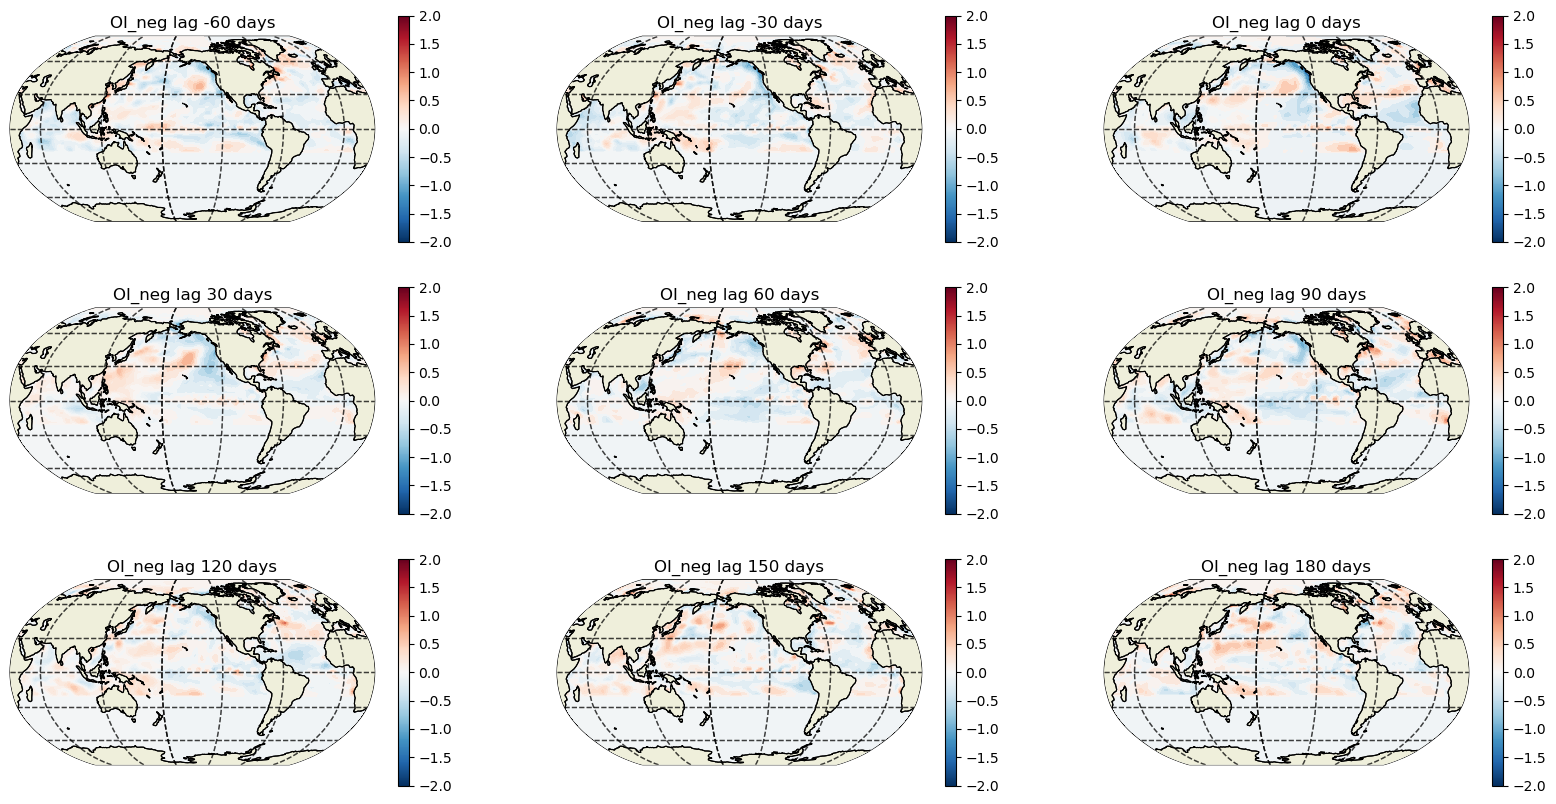

In [11]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      OI_dict[f'lag{lag}'],
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap='RdBu_r', 
                                      cmin = -2, cmax = 2,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"OI_neg lag {lag} days")
    subplot_idx += 1

# plt.title("Optimal Inputs")
plt.show()

In [12]:
ds_oi = xr.Dataset()

ds_oi = ds_oi.assign(OI_minus60 = xr.DataArray(OI_dict['lag-60']),
                     OI_minus30 = xr.DataArray(OI_dict['lag-30']),
                     OI_0  = xr.DataArray(OI_dict['lag0']),
                     OI_30 = xr.DataArray(OI_dict['lag30']),
                     OI_60 = xr.DataArray(OI_dict['lag60']),
                     OI_90 = xr.DataArray(OI_dict['lag90']),
                     OI_120 = xr.DataArray(OI_dict['lag120']),
                     OI_150 = xr.DataArray(OI_dict['lag150']),
                     OI_180 = xr.DataArray(OI_dict['lag180']))

ds_oi.to_netcdf('LRP_output_forHelen/OI_v4r5_neg.nc')